In [1]:
import glob, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import glob
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from sklearn.metrics import accuracy_score
fft_size = 16777216
time_res = 64e-6 # in seconds
T_obs = (fft_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(fft_size, d=64e-6)
freq_res = 1/(T_obs*60)

2023-06-13 19:51:48.323984: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
cur_dir = ''
run = 'runBB'
X_train = np.load(cur_dir + f'raw_data/{run}/train_data_classifier.npy').astype(np.float64)
X_test = np.load(cur_dir + f'raw_data/{run}/test_data_classifier.npy').astype(np.float64)
X_val = np.load(cur_dir + f'raw_data/{run}/val_data_classifier.npy').astype(np.float64)
X_train = X_train/np.max(X_train,axis=1)[:,None]
X_test = X_test/np.max(X_test,axis=1)[:,None]
X_val = X_val/np.max(X_val,axis=1)[:,None]

Y_train = np.load(cur_dir + f'raw_data/{run}/train_labels_classifier.npy').astype(np.float64)
Y_test = np.load(cur_dir + f'raw_data/{run}/test_labels_classifier.npy').astype(np.float64)
Y_val = np.load(cur_dir + f'raw_data/{run}/val_labels_classifier.npy').astype(np.float64)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1) 

Y_train = (Y_train.reshape(Y_train.shape[0],1))
Y_val = (Y_val.reshape(Y_val.shape[0],1))
Y_test = (Y_test.reshape(Y_test.shape[0],1))

In [3]:
test_indices = np.load(cur_dir + f'raw_data/{run}/test_indices.npy')
labels_df = pd.read_csv(cur_dir + f'meta_data/labels_{run}.csv')

In [4]:
def period_accuracy(y_true, y_pred):
    # Ensure the predictions are the same shape as the true values
    assert y_true.shape == y_pred.shape
    return accuracy_score(y_true, y_pred)

In [5]:
# Load the best model after training
best_model = tf.keras.models.load_model("models/chunk_classify_cnn_1214123_checkpoint.h5")

2023-06-13 19:52:09.151847: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-13 19:52:09.153180: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-13 19:52:09.735269: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-13 19:52:09.735366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hercules12): /proc/driver/nvidia/version does not exist
2023-06-13 19:52:09.737044: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

In [6]:
Y_pred = best_model.predict(X_test)

2023-06-13 19:52:11.025542: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-13 19:52:11.026054: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


In [7]:
Y_pred.shape

(1600, 4)

In [8]:
Y_pred2 = np.argmax(Y_pred, axis=-1)

In [9]:
Y_pred2 = Y_pred2.reshape(Y_pred.shape[0],1)

In [10]:
accuracy = period_accuracy(Y_test, Y_pred2)
print("Period accuracy: ", accuracy)

Period accuracy:  0.99125


In [34]:
max_dev_list = np.where(np.abs(Y_pred2.astype(int) - Y_test.astype(int)) == 1)[0]

In [45]:
#suppress float
np.set_printoptions(suppress=True)

for i in max_dev_list:
    print(i,Y_pred2[i], Y_test[i])
    print(Y_pred[i])

126 [2] [1.]
[0.         0.00006591 0.9999341  0.        ]
189 [2] [1.]
[0.         0.15106156 0.84893847 0.        ]
447 [1] [2.]
[0.         0.5816197  0.41838035 0.        ]
725 [2] [1.]
[0.00000021 0.00548399 0.9945111  0.00000466]
841 [1] [2.]
[0.         0.60104233 0.39895764 0.        ]
1362 [2] [1.]
[0.00000001 0.3454114  0.6545886  0.00000001]


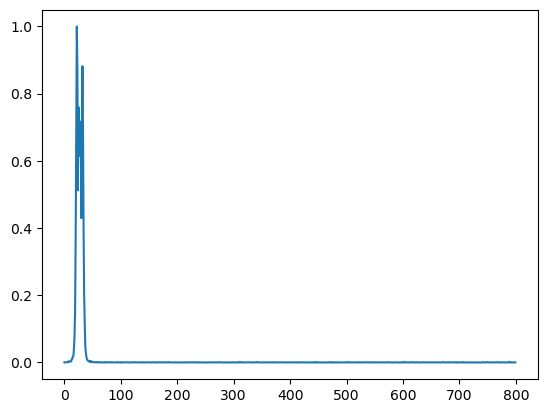

In [51]:
plt.plot(X_test[1362])

In [44]:
np.sum(Y_pred[7])

1.0

In [28]:
Y_test[139]

array([1.])

In [24]:
Y_test[np.where(np.abs(Y_pred2.astype(int) - Y_test.astype(int)) == 2),0].astype(int)

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [11]:
Y_pred2

array([[0],
       [1],
       [0],
       ...,
       [1],
       [3],
       [3]])